In [1]:
from __future__ import print_function, division
from collections import OrderedDict
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


x_start = np.load('data/gsn_img_uint8.npy')
y_start = np.load('data/gsn_msk_uint8.npy')

x_test = np.load('data/test_gsn_image.npy')
y_test = np.load('data/test_gsn_mask.npy')


# print(x.shape, y.shape)

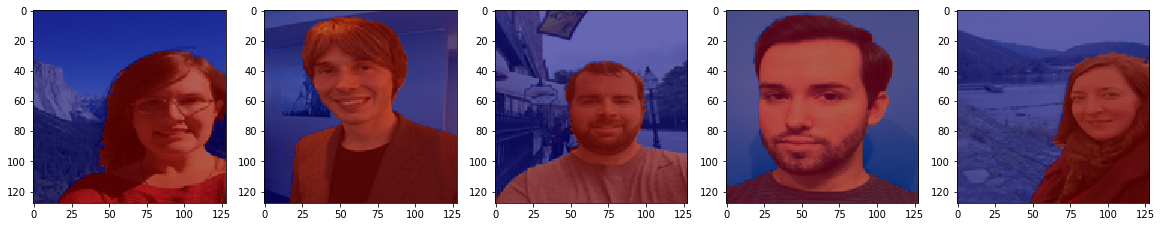

In [45]:
from matplotlib import pyplot as plt

def imshow(img):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img,aspect='auto')
    plt.show()

def maskshow(mask):
    img = np.zeros((mask.shape[0], mask.shape[1], 3))
    img[:] = mask
    plt.imshow(img)
    plt.show()

def imshow_many(imgs):
    n = imgs.shape[0]
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if(imgs.shape[3] == 1) :
            imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
        sub.imshow(imgs[i], interpolation='nearest')

def imshow_masked(samples):
    n = len(samples)
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        image = samples[i]['image']
        mask = samples[i]['mask']
        if torch.is_tensor(image) :
            image = image.permute(1,2,0)
        if torch.is_tensor(mask) :
            mask = mask.permute(1,2,0)
        mask = mask.reshape((mask.shape[0], mask.shape[1]))
        sub.imshow(image, interpolation='nearest')
        sub.imshow(mask, interpolation='nearest', cmap='jet', alpha=0.6)

start = 0
end = 5
samples = [{'image' : a, 'mask' : b} for a,b in zip(x_start[start:end], y_start[start:end])]
imshow_masked(samples)

In [3]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        resized_mask = transform.resize(mask, (new_h, new_w))
        mask = (resized_mask > 0.5).astype(resized_mask.dtype)

        return {'image': img, 'mask': mask}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

In [4]:
class myDataset(Dataset):
    """Images and masks dataset."""

    def __init__(self, gsn_img, gsn_mask, transform=None):
        """
        Args:
            gsn_img (np.array): numpy array of images
            gsn_mask (np.array): numpy array of masks
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = gsn_img
        self.masks = gsn_mask
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        mask = self.masks[idx]

        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [5]:
import random

def identity(data):
    return data

def horizontalSymmetry(data):
    newData = np.zeros_like(data)
    numRows = data.shape[0]
    numCols = data.shape[1]
    for i in range(numRows):
        for j in range(numCols):
            newData[numRows - i  - 1][j] = data[i][j]
    return newData

def verticalSymmetry(data):
    newData = np.zeros_like(data)
    numRows = data.shape[0]
    numCols = data.shape[1]
    for i in range(numRows):
        for j in range(numCols):
            newData[i][numCols - j - 1] = data[i][j]
    return newData

def diagonalSymmetry1(data):
    newData = np.zeros_like(data)
    numRows = data.shape[0]
    numCols = data.shape[1]
    for i in range(numRows):
        for j in range(numCols):
            newData[numRows - i - 1][numCols - j - 1] = data[j][i]
    return newData

def diagonalSymmetry2(data):
    newData = np.zeros_like(data)
    numRows = data.shape[0]
    numCols = data.shape[1]
    for i in range(numRows):
        for j in range(numCols):
            newData[i][j] = data[j][i]
    return newData

def rotateRight(data):
    newData = np.zeros_like(data)
    numRows = data.shape[0]
    numCols = data.shape[1]
    for i in range(numRows):
        for j in range(numCols):
            newData[j][numRows - i - 1] = data[i][j]
    return newData

def rotateLeft(data):
    newData = np.zeros_like(data)
    numRows = data.shape[0]
    numCols = data.shape[1]
    for i in range(numRows):
        for j in range(numCols):
            newData[numCols - j - 1][i] = data[i][j]
    return newData

def rotateTwice(data):
    newData = np.zeros_like(data)
    numRows = data.shape[0]
    numCols = data.shape[1]
    for i in range(numRows):
        for j in range(numCols):
            newData[numCols - j - 1][numRows - i - 1] = data[j][i]
    return newData

def randomDataAug(data, mask):
    dataAug = [identity, horizontalSymmetry, verticalSymmetry,
               diagonalSymmetry1, diagonalSymmetry2, rotateLeft,
               rotateRight, rotateTwice]

    f = dataAug[random.randrange(0, 7, 1)]
    return f(data), f(mask)


def randomDataAugForDataset(data, mask):
    assert(data.shape[0] == mask.shape[0])
    for i in range(data.shape[0]):
        data[i], mask[i] = randomDataAug(data[i], mask[i])
    return data, mask

def allAugumentation(data, mask):
    data1 = [8 * data.shape[0]]
    mask1 = [8 * mask.shape[0]]
    for i in range(data.shape[0]):
        data1[8 * i], mask1[8 * i] = identity(data[i], mask[i])
        data1[8 * i + 1], mask1[8 * i + 1] = horizontalSymmetry(data[i], mask[i])
        data1[8 * i + 2], mask1[8 * i + 2] = verticalSymmetry(data[i], mask[i])
        data1[8 * i + 3], mask1[8 * i + 3] = diagonalSymmetry1(data[i], mask[i])
        data1[8 * i + 4], mask1[8 * i + 4] = diagonalSymmetry2(data[i], mask[i])
        data1[8 * i + 5], mask1[8 * i + 5] = rotateLeft(data[i], mask[i])
        data1[8 * i + 6], mask1[8 * i + 6] = rotateRight(data[i], mask[i])
        data1[8 * i + 7], mask1[8 * i + 7] = rotateTwice(data[i], mask[i])
    return data1, mask1

In [6]:

scale = Rescale(256)
crop = RandomCrop(127)
composed = transforms.Compose([Rescale(150),
                               RandomCrop(128),
                              ToTensor(),
                              ])

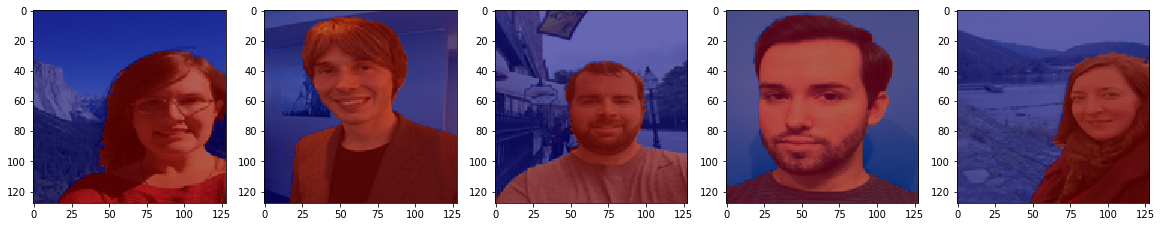

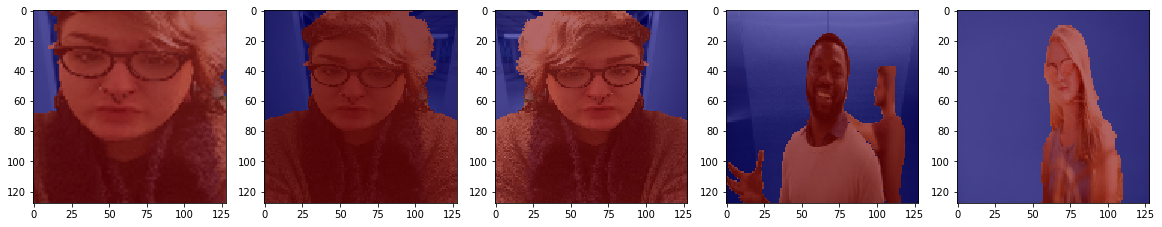

In [7]:
train_dataset = myDataset(x_start, y_start)
# x1, y1 = randomDataAugForDataset(x, y)
# train_dataset_aug = myDataset(x1, y1, transform=composed)
# x_aug_test, y_aug_test = allAugumentation(x_test, y_test)
test_dataset = myDataset(x_test, y_test, transform=ToTensor())

imshow_masked([train_dataset[i] for i in range(5)])

# imshow_masked([train_dataset_aug[i] for i in range(5)])
imshow_masked([test_dataset[i] for i in range(5)])

In [8]:
# trainloader = DataLoader(train_dataset_aug, batch_size=4,
#                         shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [13]:

torch.set_default_tensor_type(torch.cuda.DoubleTensor)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [10]:
epochs = 10
lr = 0.0001


def log_loss_summary(loss, step, prefix=""):
    print("epoch {} | {}: {}".format(step + 1, prefix + "loss", np.mean(loss)))



class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

def IOU(preds, truth):
    intersection = (np.logical_and((preds > 0.5) == 1, (truth > 0.5) == 1)).sum().item()
    union = (np.logical_or((preds > 0.5),(truth > 0.5))).sum().item()
    return intersection/union

unet = UNet(in_channels=3, out_channels=1)

x_train = np.load('data/gsn_img_uint8.npy')
y_train = np.load('data/gsn_msk_uint8.npy')

x_test = np.load('data/test_gsn_image.npy')
y_test = np.load('data/test_gsn_mask.npy')

composed_test = transforms.Compose([Rescale(128),
                              ToTensor(),
                              ])

test_dataset = myDataset(x_test, y_test, transform=composed_test)
testloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=1)

def validate(testloader):
    loss_valid = []
    dsc_loss = DiceLoss()
    validation_pred = []
    validation_true = []
    IOU_avg_sum = 0
    batches = 0
    for i, data in enumerate(testloader, 0):

        x = data['image']
        y_true = data['mask']

        x, y_true = x.to(device), y_true.to(device)
        y_pred = unet(x)
        loss = dsc_loss(y_pred, y_true)
        loss_valid.append(loss.item())
        y_pred_np = y_pred.detach().cpu().numpy()
        validation_pred.extend(
            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
        )
        y_true_np = y_true.detach().cpu().numpy()
        validation_true.extend(
            [y_true_np[s] for s in range(y_true_np.shape[0])]
        )
        batch_size = y_pred_np.shape[0]
        IOU_batch = [IOU(y_pred_np[i],y_true_np[i]) for i in range(batch_size) ]
        IOU_avg_sum += sum(IOU_batch)/batch_size
    return IOU_avg_sum/500

def train_validate(x_start, y_start):
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    # x1, y1 = randomDataAugForDataset(x, y)
    # train_dataset_aug = myDataset(x1, y1, transform=composed)
    # trainloader = DataLoader(train_dataset_aug, batch_size=4,
    #                     shuffle=True, num_workers=4)

    unet.to(device)

    optimizer = optim.Adam(unet.parameters(), lr=lr)

    loss_train_log = []
    loss_valid_log = []
    IOU_log = []

    loss_train = []
    loss_valid = []

    dsc_loss = DiceLoss()

    step = 0

    for epoch in range(epochs):
        x1, y1 = randomDataAugForDataset(x_start, y_start)
        train_dataset_aug = myDataset(x1, y1, transform=composed)
        trainloader = DataLoader(train_dataset_aug, batch_size=4, shuffle=True, num_workers=4)
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()

            validation_pred = []
            validation_true = []
            IOU_avg_sum = 0
            batches = 0

            for i, data in enumerate(trainloader, 0):
                if phase == "train":
                    step += 1

                x = data['image']
                y_true = data['mask']

                x, y_true = x.to(device), y_true.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)

                    loss = dsc_loss(y_pred, y_true)

                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        batch_size = y_pred_np.shape[0]
                        IOU_batch = [IOU(y_pred_np[i],y_true_np[i]) for i in range(batch_size) ]
                        IOU_avg_sum += sum(IOU_batch)/batch_size
                        batches += 1

                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()

            if phase == "train":
                loss_train_log.append(np.mean(loss_train))
                log_loss_summary(loss_train, epoch)
                loss_train = []

            if phase == "valid":
                iou = IOU_avg_sum/batches
                print("IOU=", iou)
                IOU_log.append(iou)
                loss_valid_log.append(np.mean(loss_valid))
                log_loss_summary(loss_valid, epoch, prefix="val_")
                loss_valid = []
            print("Test IoU=", validate(testloader))

    return loss_train_log,loss_valid_log, IOU_log

In [ ]:
import time
x_start = np.load('data/gsn_img_uint8.npy')
y_start = np.load('data/gsn_msk_uint8.npy')
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
print(device)
start_time = time.time()
loss_train_log,loss_valid_log, IOU_log = train_validate(x_start, y_start)
print("--- %s seconds ---" % (time.time() - start_time))

cuda:0


In [18]:
# print(x.shape)
# print(y.shape)

(2000, 128, 128, 3)
(2000, 128, 128, 1)


In [14]:
# torch.save(unet.state_dict(), "./u-net_30.pth")
print("saved")

saved


In [11]:
x_train = np.load('data/gsn_img_uint8.npy')
y_train = np.load('data/gsn_msk_uint8.npy')

x_test = np.load('data/test_gsn_image.npy')
y_test = np.load('data/test_gsn_mask.npy')


In [14]:
unet = UNet(in_channels=3, out_channels=1)
unet.load_state_dict(torch.load("./u-net_30.pth"))
unet.eval();

In [44]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
# print(device)
# test_dataset = myDataset(x_start, y_start)
# trainloader = DataLoader(train_dataset, batch_size=1,
#                          shuffle=True, num_workers=4)
composed_test = transforms.Compose([Rescale(128),
                              ToTensor(),
                              ])

test_dataset = myDataset(x_test, y_test, transform=composed_test)
testloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=1)


def IOU(preds, truth):
    intersection = (np.logical_and((preds > 0.5) == 1, (truth > 0.5) == 1)).sum().item()
    union = (np.logical_or((preds > 0.5),(truth > 0.5))).sum().item()
    return intersection

def pixel_accuracy(outputs, labels):
    same = (np.logical_and((outputs > 0.5) == 1 , (labels > 0.5) == 1)).sum() + (np.logical_and((outputs > 0.5) ==0 , (labels > 0.5) == 0)).sum()
    return (same / (outputs.shape[0] * outputs.shape[1] * outputs.shape[2]))

pixel_acc_log = []
def validate(testloader):
    pixel_acc = 0
    pixel_acc_batch = []
    loss_valid = []
    dsc_loss = DiceLoss()
    validation_pred = []
    validation_true = []
    IOU_avg_sum = 0
    batches = 0
    for i, data in enumerate(testloader, 0):

        x = data['image']
        y_true = data['mask']

        x, y_true = x.to(device), y_true.to(device)
        y_pred = unet(x)
        loss = dsc_loss(y_pred, y_true)
        loss_valid.append(loss.item())
        y_pred_np = y_pred.detach().cpu().numpy()
        validation_pred.extend(
            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
        )
        y_true_np = y_true.detach().cpu().numpy()
        validation_true.extend(
            [y_true_np[s] for s in range(y_true_np.shape[0])]
        )
        batch_size = y_pred_np.shape[0]
        IOU_batch = [IOU(y_pred_np[i],y_true_np[i]) for i in range(batch_size) ]
        pixel_acc_batch = [pixel_accuracy(y_pred_np[i],y_true_np[i]) for i in range(batch_size) ]
        pixel_acc_log.append(pixel_acc_batch)
        pixel_acc += sum(pixel_acc_batch)/batch_size
        IOU_avg_sum += sum(IOU_batch)/batch_size
    print("Pixel accuracy: ", pixel_acc/500)

    return IOU_avg_sum/500

validate(testloader)

Pixel accuracy:  0.9110931396484375


8868.586

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


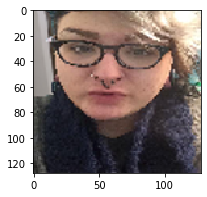

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

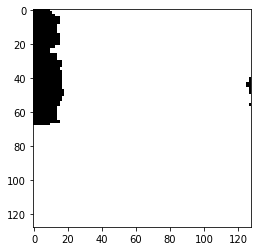

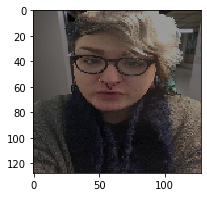

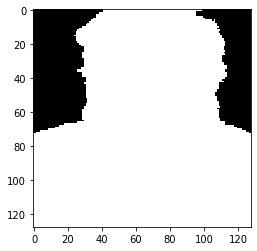

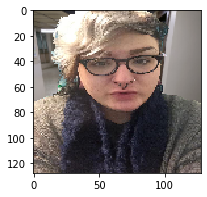

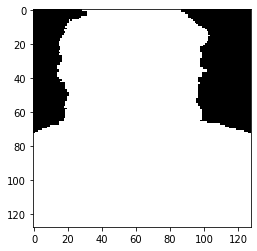

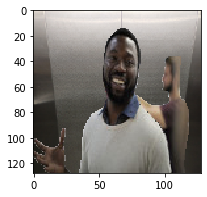

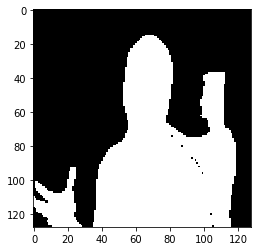

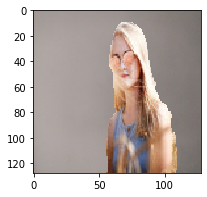

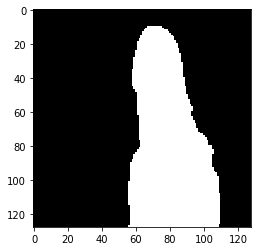

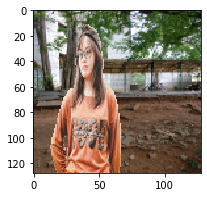

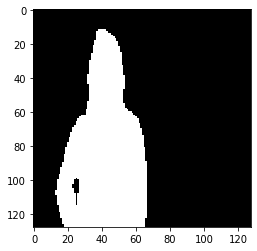

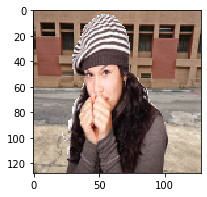

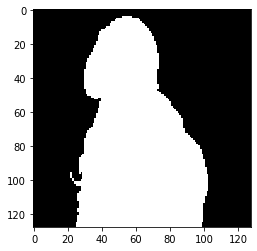

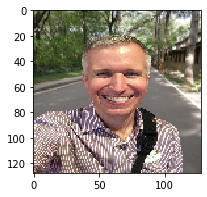

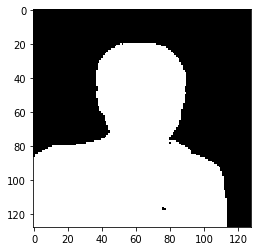

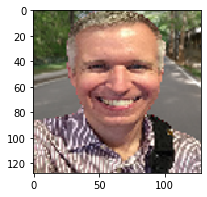

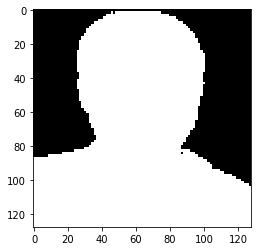

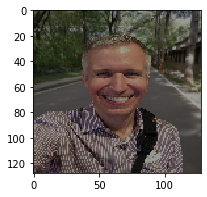

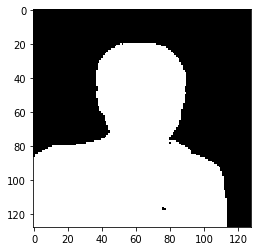

In [53]:
pixel_acc_log = np.array(pixel_acc_log)
pixel_log_idx = np.argsort(pixel_acc_log)
for i in range(10):
    print(pixel_log_idx[i])
    imshow(x_test[i])
    maskshow(y_test[i])



cuda:0
epoch 1 | loss: 0.3229628301881912
IOU= 0.6107253558199836
epoch 1 | val_loss: 0.29252605718396146
epoch 2 | loss: 0.2410536519589737
IOU= 0.7128636331367715
epoch 2 | val_loss: 0.2232347783184074
epoch 3 | loss: 0.18996457807644446
IOU= 0.7306724343590257
epoch 3 | val_loss: 0.1869540467638733
epoch 4 | loss: 0.15192570548616635
IOU= 0.8492908443576496
epoch 4 | val_loss: 0.1232078598712004
epoch 5 | loss: 0.12539305016688201
IOU= 0.8558716513232173
epoch 5 | val_loss: 0.10793262820528125
epoch 6 | loss: 0.10460445729518361
IOU= 0.8739450520650325
epoch 6 | val_loss: 0.08873343967740834
epoch 7 | loss: 0.0920800215935341
IOU= 0.8818264846868389
epoch 7 | val_loss: 0.07668970535058152
epoch 8 | loss: 0.08005936810889568
IOU= 0.8916937923218503
epoch 8 | val_loss: 0.06789351969602359
epoch 9 | loss: 0.07143216123091005
IOU= 0.8978973843108067
epoch 9 | val_loss: 0.06140367107366428
epoch 10 | loss: 0.06533271153935732
IOU= 0.9039735823643282
epoch 10 | val_loss: 0.05561462396135164
epoch 11 | loss: 0.060551900435599736
IOU= 0.9012471652418338
epoch 11 | val_loss: 0.0555452000743715
epoch 12 | loss: 0.05891447824300349
IOU= 0.9082536339870975
epoch 12 | val_loss: 0.0501246507471287
epoch 13 | loss: 0.05434792206058641
IOU= 0.9171001786752643
epoch 13 | val_loss: 0.04497247463820023
epoch 14 | loss: 0.05157883886467715
IOU= 0.919500691964596
epoch 14 | val_loss: 0.04297047470301419
epoch 15 | loss: 0.049760502068475126
IOU= 0.921789887152932
epoch 15 | val_loss: 0.04155907975543034
epoch 16 | loss: 0.04666540888330251
IOU= 0.9215410060912682
epoch 16 | val_loss: 0.04171651168083207
epoch 17 | loss: 0.04274391866004984
IOU= 0.9273335143240082
epoch 17 | val_loss: 0.0384356535118566
epoch 18 | loss: 0.04312041944743065
IOU= 0.930665064972772
epoch 18 | val_loss: 0.03596254800964544
epoch 19 | loss: 0.042045611979867774
IOU= 0.929984157512026
epoch 19 | val_loss: 0.036176261374042666
epoch 20 | loss: 0.04081415248630512
IOU= 0.9301257430410407
epoch 20 | val_loss: 0.03624225179569782
epoch 21 | loss: 0.041695022975641614
IOU= 0.929130325216561
epoch 21 | val_loss: 0.03653728584979102
epoch 22 | loss: 0.03952521300249046
IOU= 0.9295218546842913
epoch 22 | val_loss: 0.03628802346854384
epoch 23 | loss: 0.03842043637892587
IOU= 0.931283263436489
epoch 23 | val_loss: 0.03541305706030195
epoch 24 | loss: 0.03864558888724026
IOU= 0.9377762307704886
epoch 24 | val_loss: 0.03154110638060913
epoch 25 | loss: 0.03592256534811634
IOU= 0.9378908116781917
epoch 25 | val_loss: 0.03183497543200838
epoch 26 | loss: 0.03557820861625963
IOU= 0.9311899423239822
epoch 26 | val_loss: 0.03535442274328423
epoch 27 | loss: 0.03636748409258839
IOU= 0.9416457659286549
epoch 27 | val_loss: 0.029949579859262117
epoch 28 | loss: 0.03490375881259212
IOU= 0.9420566901101362
epoch 28 | val_loss: 0.029366432841330635
epoch 29 | loss: 0.035221242120397026
IOU= 0.9412567819831317
epoch 29 | val_loss: 0.030046404772609094
epoch 30 | loss: 0.03477402625606368
IOU= 0.9462450374388038
epoch 30 | val_loss: 0.027063182073661245
--- 10300.543855428696 seconds ---